In [ ]:
str.

In [71]:
import tqdm
import json
from vowpalwabbit import pyvw

# modelfile = "wiki/nlwiki-20220301/experiments/clean-utrecht.bal.nons.16b.vw"
# datafile = "wiki/nlwiki-20220301/experiments/clean-utrecht.bal.nons.dat"
# anchor_json = "wiki/nlwiki-20220301/experiments/clean-utrecht.json"

modelfile = "wiki/nlwiki-20220301/experiments/clean-q0.25.utrecht.24b.vw"
datafile = "wiki/nlwiki-20220301/experiments/clean-q0.25.utrecht.dat"
anchor_json = "wiki/nlwiki-20220301/experiments/clean-q0.25.json"



# modelfile = "wiki/nlwiki-20220301/experiments/clean-q0.25.vw"
# datafile = "wiki/nlwiki-20220301/experiments/clean-q0.25.dat"
# anchor_json = "wiki/nlwiki-20220301/experiments/clean-q0.25.json"

# modelfile = "wiki/nlwiki-20220301/experiments/clean-q0.25.nons.vw"
# datafile = "wiki/nlwiki-20220301/experiments/clean-q0.25.bal.nons.dat"
# anchor_json = "wiki/nlwiki-20220301/experiments/clean-q0.25.json"


# modelfile = "wiki/nlwiki-20220301/experiments/clean-q0.25.nons.shuf.28b.vw"
# datafile = "wiki/nlwiki-20220301/experiments/clean-q0.25.bal.nons.dat"
# anchor_json = "wiki/nlwiki-20220301/experiments/clean-q0.25.json"


# modelfile = "wiki/nlwiki-20220301/experiments/clean-q0.25.bal.nons.shuf.utrecht.462.28b.vw"
# datafile = "wiki/nlwiki-20220301/experiments/clean-q0.25.bal.nons.shuf.utrecht.dat"
# anchor_json = "wiki/nlwiki-20220301/experiments/clean-q0.25.json"

surface_weights = json.load(open(anchor_json))
surface_weights = {
    m:{int(e.replace('Q','')):c for e,c in ec.items()} 
    for m, ec in surface_weights.items()
}
ents = set(e for ec in surface_weights.values() for e in ec)
e_i = {e:i for i,e in enumerate(sorted(ents))}
i_e = dict(enumerate(sorted(ents)))

print(len(e_i))

# audit = 'wiki/nlwiki-20220301/experiments/clean-q0.25.hash262144.utrecht.vw.audit'
# !rm $audit
model = pyvw.Workspace(
    initial_regressor=modelfile,
    # audit_regressor=audit,
)

77953


using no cache
Reading datafile = none
num sources = 0
Num weight bits = 24
learning rate = 0.5
initial_t = 20943
power_t = 0.5
Enabled reductions: gd, scorer-identity, csoaa
Input label = cs
Output pred = multiclass
average  since         example        example        current        current  current
loss     last          counter         weight          label        predict features

finished run
number of examples = 1001
weighted example sum = 1001.000000
weighted label sum = 0.000000
average loss = 1.844156
total feature number = 120298


In [72]:
w = surface_weights['utrecht']
print(w)
print(*zip(w, [e_i[e] for e in w]))

{803: 15549, 776: 3887, 707767: 527, 575655: 316, 261716: 255, 221653: 210, 2679365: 133, 2012748: 22, 24680: 18, 18108: 18, 85308316: 15, 847384: 10, 2193594: 10}
(803, 462) (776, 441) (707767, 31788) (575655, 27334) (261716, 18763) (221653, 17461) (2679365, 64109) (2012748, 52527) (24680, 4459) (18108, 3912) (85308316, 77282) (847384, 35570) (2193594, 55993)


In [73]:
lines = []
for i, l in enumerate(open(datafile)):
    labels = set(int(a.split(':')[0]) for a in l.split(' |', 1)[0].split())
    if (462 not in i_e) or (462 in labels):
        lines.append(l)
    print(f'{i:010d}', end='\r')
    if i > 200000: break
    if len(lines) > 1000: break
print()
print(len(lines))

0000001000
1001


In [74]:
select_ents = surface_weights['utrecht']

import pandas as pd
import sqlite3
from collections import *

con = sqlite3.connect('wiki/nlwiki-20220301/index_nlwiki-20220301.db')
ent_label = {}
for e in select_ents:
    l = pd.read_sql_query(f'select * from mapping where wikidata_id="Q{e}" limit 1', con)
    ent_label[e] = l['wikipedia_title'][0]
    
dict(Counter(ent_label[e] for l in lines for e in [i_e[int(l.split(' ',1)[0].split(':')[0])]] if e in ent_label).most_common())

{'Utrecht_(stad)': 588,
 'Utrecht_(provincie)': 229,
 'Sticht_Utrecht': 94,
 'Aartsbisdom_Utrecht_(rooms-katholiek)': 38,
 'Station_Utrecht_Centraal': 21,
 'Universiteit_Utrecht': 14,
 'Heerlijkheid_Utrecht': 11,
 'Utrecht_(Zuid-Afrika)': 4,
 'FC_Utrecht': 2}

In [75]:
lines[:3]

['17461:0 462:9 441:8 31788:6 27334:5 18763:5 64109:4 52527:3 4459:2 3912:2 77282:2 35570:2 55993:2 |utrecht amsterdam uva vu leiden nijmegen utrecht leuven\n',
 '462:0 441:8 31788:6 27334:5 18763:5 17461:5 64109:4 52527:3 4459:2 3912:2 77282:2 35570:2 55993:2 |utrecht arnhem wordt als arneym voor het eerst genoemd in 893 in een register van de bezittingen van de abdij van prüm in de eifel het wordt beschreven als een aan sint maarten gewijde kerk met omliggende landerijen hoewel de vroege sporen van nederzettingen getoond hebben dat de vroege arnhemmers zijn afgedaald uit de hoger gelegen bossen is arnhem oorspronkelijk niet gebouwd op de oevers van de rijn maar op het hoger gelegen deel langs de sint jansbeek arnhem ontstond op de plek waar de weg tussen nijmegen en utrecht zutphen zich splitste zeven sprengbeken voorzagen de stad van water en pas toen de loop van de rijn in 1530 door de arnhemmers verlegd werd kwam arnhem aan de rivier te liggen\n',
 '462:0 441:8 31788:6 27334:5 187

In [76]:
from collections import *
import tqdm
weight = defaultdict(lambda: defaultdict())
hash_fc = defaultdict(Counter)
opts = {o.name: o.value for cat, opts in model.get_config()['general'] for o in opts}
bits = opts['bit_precision']
print(bits, 'bits')
ns = ('.nons' not in modelfile)
print('ns', ns)

for line in tqdm.tqdm(lines):
    feats = line.split('|', 1)[1].split()[int(ns):] + ['Constant']
    hashes = list(model.parse(line).iter_features())
    assert len(feats) == len(hashes)
    for fn,(f,w) in zip(feats, hashes):
        fh = (f % 2**bits) # feature hash
        hash_fc[fh][fn] += 1
        for e,name in ent_label.items():
            w = model.get_weight(fh + e_i[e])
            if w:
                weight[name][fh] = w
len(weight)

24 bits
ns True


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:01<00:00, 713.75it/s]


0

<AxesSubplot:>

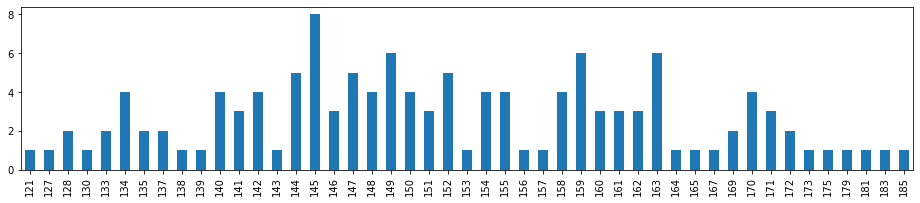

In [77]:
pd.Series(Counter(len(v) for v in hash_fc.values())).sort_index().plot.bar(figsize=(16,3))

In [67]:
len(ents), len(hash_fc)

(28, 2047)

In [78]:
n = None
from sklearn.metrics import classification_report
y_true, y_pred = [int(l.split(':',1)[0]) for l in lines[:n]], [model.predict(l) for l in lines[:n]]
print('true', {ent_label.get(i_e[i]):c for i,c in Counter(y_true).most_common(5)})
print('pred', {ent_label.get(i_e[i]):c for i,c in Counter(y_pred).most_common()})
labels, target_names = zip(*{e_i[e]:l for e,l in ent_label.items()}.items())
print(classification_report(y_true, y_pred, labels=labels, target_names=target_names))

true {'Utrecht_(stad)': 588, 'Utrecht_(provincie)': 229, 'Sticht_Utrecht': 94, 'Aartsbisdom_Utrecht_(rooms-katholiek)': 38, 'Station_Utrecht_Centraal': 21}
pred {'Utrecht_(stad)': 490, 'BVC_Utrecht': 302, 'Utrechts_Conservatorium': 141, 'FC_Utrecht': 27, 'Utrecht_(provincie)': 23, 'Utrecht_(Zuid-Afrika)': 7, 'Hr.Ms._Utrecht_(1901)': 5, 'Vechtsebanen': 3, 'Station_Utrecht_Centraal': 2, 'Heerlijkheid_Utrecht': 1}
                                       precision    recall  f1-score   support

                       Utrecht_(stad)       0.74      0.62      0.68       588
                  Utrecht_(provincie)       0.83      0.08      0.15       229
                       Sticht_Utrecht       0.00      0.00      0.00        94
             Station_Utrecht_Centraal       0.00      0.00      0.00        21
Aartsbisdom_Utrecht_(rooms-katholiek)       0.00      0.00      0.00        38
                 Universiteit_Utrecht       0.00      0.00      0.00        14
                 Heerlijkheid_U

2.000000 2.000000            1            1.0          known          35570        8
2.000000 2.000000            2            2.0          known          77282      122
2.000000 2.000000            4            4.0          known          77282       64
4.375000 6.750000            8            8.0          known            462       93
3.812500 3.250000           16           16.0          known          77282       69
2.437500 1.062500           32           32.0          known            462       73
2.046875 1.656250           64           64.0          known          77282       35
2.070312 2.093750          128          128.0          known            462      319
2.269531 2.468750          256          256.0          known            462      404
2.308594 2.347656          512          512.0          known          35570       48
/home/bbkruit/scratch/anaconda3/envs/takco2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and

In [79]:
df

0
Utrecht_(stad)        (australië, 11) -0.080667
                      (in, 4151)       0.028470
                      (1988, 22)      -0.293436
                      (nederlaag, 11)  0.311243
                      (koningin, 40)  -0.041462
...                                         ...
Hr.Ms._Utrecht_(1901) (boerhaave, 18) -0.100293
                      (eems, 22)       0.001402
                      (ernst, 15)      0.030606
                      (toegekend, 14)  0.052704
                      (albrecht, 22)  -0.025792

[12324 rows x 1 columns]

In [70]:
hash_f = {h: fc.most_common(1)[0] for h, fc in hash_fc.items()}
df = pd.concat({
    k: pd.DataFrame.from_dict({hash_f[h]:w for h,w in v.items() if hash_f[h][1] > 10}, orient='index') 
    for k,v in weight.items()
})

def topfeat(gr):
    gr = gr.droplevel(0).rename(columns={0:'weight'})
    return gr.loc[gr['weight'].apply('abs').sort_values().index[::-1]].head(10).sort_values('weight').reset_index()
# df.loc['Utrecht_(stad)']
df.groupby(level=0).apply(topfeat).swaplevel().unstack().swaplevel(axis=1).sort_index(axis=1).T.loc[list(ent_label.values())]

0  \
Utrecht_(stad)                        index      (binnenstad, 17)   
                                      weight            -1.075986   
Utrecht_(provincie)                   index      (provincie, 196)   
                                      weight            -3.303146   
Sticht_Utrecht                        index       (bisschop, 155)   
                                      weight            -0.630954   
Station_Utrecht_Centraal              index         (dichter, 25)   
                                      weight             -0.33774   
Aartsbisdom_Utrecht_(rooms-katholiek) index   (aartsbisschop, 46)   
                                      weight            -0.401328   
Universiteit_Utrecht                  index        (volledig, 13)   
                                      weight            -0.173396   
Heerlijkheid_Utrecht                  index      (stadhouder, 50)   
                                      weight            -0.227252   
Vechtsebanen                          index       (boerhaave, 18)   
                                      weight            -0.126856   
FC_Utrecht                            index             (uur, 24)   
                                      weight            -0.193801   
Utrecht_(Zuid-Afrika)                 index             (uur, 24)   
                                      weight            -0.197946   
BVC_Utrecht                           index             (uur, 24)   
                                      weight            -0.193535   
Utrechts_Conservatorium               index             (uur, 24)   
                                      weight            -0.194399   
Hr.Ms._Utrecht_(1901)                 index             (uur, 24)   
                                      weight            -0.192847   

                                                             1  \
Utrecht_(stad)                        index        (stad, 414)   
                                      weight         -1.029332   
Utrecht_(provincie)                   index           (82, 16)   
                                      weight         -1.146211   
Sticht_Utrecht                        index       (schaal, 17)   
                                      weight         -0.239465   
Station_Utrecht_Centraal              index      (premier, 29)   
                                      weight         -0.296705   
Aartsbisdom_Utrecht_(rooms-katholiek) index    (bisdommen, 14)   
                                      weight         -0.378339   
Universiteit_Utrecht                  index    (componist, 40)   
                                      weight         -0.173014   
Heerlijkheid_Utrecht                  index           (63, 11)   
                                      weight         -0.180565   
Vechtsebanen                          index           (63, 11)   
                                      weight         -0.117712   
FC_Utrecht                            index      (positie, 17)   
                                      weight          -0.18177   
Utrecht_(Zuid-Afrika)                 index      (positie, 17)   
                                      weight         -0.174207   
BVC_Utrecht                           index   (zogenaamde, 13)   
                                      weight         -0.154596   
Utrechts_Conservatorium               index      (positie, 17)   
                                      weight         -0.164829   
Hr.Ms._Utrecht_(1901)                 index   (zogenaamde, 13)   
                                      weight          -0.14762   

                                                             2  \
Utrecht_(stad)                        index     (holland, 206)   
                                      weight          0.894128   
Utrecht_(provincie)                   index     (europese, 27)   
                                      weight         -0.948613   
Sticht_Utrecht                        index         (luik, 27)   
                     

In [51]:
hash_f = {h: fc.most_common(1)[0] for h, fc in hash_fc.items()}
f = ('Constant',365)
# f = ('amerikaanse', 31)
# f = ('16', 24)
# f = ('rotterdam', 44)
# f = ('thunderdome', 165)
f = ('premier', 15)
h = pd.Series(hash_f)[pd.Series(hash_f) == f].index[0]
print(h)
hash_fc[h]

238813184


Counter({'laagte': 1,
         'charleroi': 2,
         'premier': 15,
         'bevorderen': 2,
         'karol': 1,
         'kensingtonsteen': 1})

In [201]:
from collections import Counter
fin = "wiki/nlwiki-20220301/experiments/clean-q0.25.hash262144.utrecht.dat"
e_count = Counter()
for example in tqdm.tqdm(open(fin).readlines()):
    clss = example.split('|',1)[0]
    for c in clss.split():
        e_count[ i_e[int(c.split(':')[0])] ] += 1
dict(e_count.most_common())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22224/22224 [00:00<00:00, 70524.24it/s]


{803: 21511,
 776: 21487,
 221653: 20943,
 707767: 20943,
 575655: 20943,
 261716: 20943,
 2679365: 20943,
 2012748: 20943,
 24680: 20943,
 18108: 20943,
 85308316: 20943,
 847384: 20943,
 2193594: 20943,
 1530142: 636,
 10043: 636,
 1030114: 636,
 2681969: 77,
 2119715: 77,
 495363: 24}

In [18]:
i_e[1]

2

In [216]:
e_i[803] # universiteit groningen

462

In [10]:
{i_e[i+1]:i for i,c in dict(params[0].value_counts()).items()}

{776: 440,
 575655: 27333,
 2679365: 64108,
 2193594: 55992,
 2012748: 52526,
 847384: 35569,
 803: 461,
 707767: 31787,
 261716: 18762,
 221653: 17460,
 24680: 4458,
 18108: 3911,
 85308316: 77281,
 1030114: 41053,
 10043: 2664,
 1530142: 46671,
 2119715: 54655,
 2681969: 64140,
 495363: 24618}

In [ ]:
# 

In [15]:
params[params[0] == 4458].sort_values(3)

,0,1,2,3
2566,4458,utrecht^barneveldse,233312618,-0.162375
5150,4458,utrecht^2013,199496042,-0.115103
3548,4458,utrecht^nederzetting,183636330,-0.105536
5146,4458,utrecht^bluesfestival,249434474,-0.101143
6375,4458,utrecht^wagenwerkplaats,123605354,-0.098780
...,...,...,...,...
3554,4458,utrecht^utrechtse,50860394,0.073711
2126,4458,utrecht^kernen,80875882,0.097736
2122,4458,utrecht^hoofdplaats,85201258,0.100328
37,4458,utrecht^utrecht,248648042,0.111593


In [189]:
import itertools
i = 0
for example in itertools.islice(open("wiki/nlwiki-20220301/experiments/clean-q0.25.hash262144.utrecht.dat"), i, i+1):
    print(example)
    p = model.audit_example(model.parse(example))
    print('predict', p)
    

17461:0 462:9 441:8 31788:6 27334:5 18763:5 64109:4 52527:3 4459:2 3912:2 77282:2 35570:2 55993:2 |utrecht amsterdam uva vu leiden nijmegen utrecht leuven

predict None


In [207]:
import pandas as pd
infile = ['evaluation/Mewsli-9/nl.tsv']
data = pd.concat([pd.read_csv(i, sep="\t", header=None, nrows=3) for i in infile])
data[1] = data[1].map(json.loads)
ids, ents, texts = data[0], data[1], data[2]

from minimel import normalize
from minimel.vectorize import vw_tok
lang = None

for i, text in enumerate(texts):
    ent_pred = {}
    if len(ents):
        for surface in ents[i]:
            pred = None
            for norm in normalize(surface, language=lang):
                ent_cand = candidates.get(norm, None)
                if ent_cand and model:
                    es = [str(ent_i[int(e)]) for e in ent_cand]
                    print(surface, ents[i][surface], ent_cand, es)
                    ns = '_'.join(vw_tok(surface))
                    item = ' '.join(es) + f' |{ns} ' + ' '.join(vw_tok(texts[i]))
                    print(item)
                    pred = i_ent[model.predict(item)]
                # elif norm in count:
                #     dist = count[norm]
                #     pred = max(dist, key=lambda x: dist[x])
                # elif surface.replace(" ", "_") in index:
                #     pred = index[surface.replace(" ", "_")]
                if pred:
                    ent_pred[surface] = int(str(pred).replace('Q',''))
    print(ent_pred)

kortsluiting 206907 {'206907': 116, '2010025': 5} ['32617', '138153']
32617 138153 |f168723 f223923 f245797 f102129 f228076 f68170 f209610 f61402 f14030 f249089 f223923 f245797 f102129 f228076 f68170 f209610 f206493 f224273 f46643 f146437 f146678 f71790 f158068 f19235 f245797 f224273 f102129 f245797 f17904 f57552 f182639 f1709 f89125 f181374 f804 f240580 f157351 f114394 f209610 f159513 f129327 f48281 f161521 f56500 f43885 f129327 f129710 f209610 f42929 f216092 f41007 f159083 f224273 f129710 f120815 f17904 f83828 f201452 f256675 f169248 f65064 f89125 f201452 f89125 f75978 f42929 f188925 f54536 f179792 f17904 f132495 f182958 f37209 f92136 f212944 f21211 f112626 f74714 f193627 f129327 f163340 f120815 f17904 f132495 f246794 f245797 f17904 f106490 f28838 f54536 f191360 f17904 f106490 f227100 f62227 f224273 f104051 f46643 f91239 f75978 f188016 f48281 f20399 f17904 f223923 f48281 f95060 f157351 f120815 f129327 f234562 f40249 f48281 f222409 f236264 f173385 f164098 f47067 f122312 f48281 f224273